# Assessing the Trained Model's Performance on the Test Set

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

from src.engine import biLSTM_engine, ResNet50_GRU_engine, MTL_engine
from src.model_transportMode import BiLSTMNetwork
from src.model_driverID import ResNet50_GRU
from src.model_multitask import MultitaskModel
from src.plot import plot_history, plot_endgame_history, MTL_plot
from src.dataset import TransportModeDataset, FeatureMapDatasetImproved, CombinedDataset

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader, random_split

In [2]:
lstm_base_dir = './data/lstm_features_labels/'
fmap_base_dir = './data/feature_maps_labels/'
np.random.seed(42)

test_datasets_mtl = CombinedDataset(fmap_base_dir, lstm_base_dir, mode='test', 
                                 rescale=False, augment=True)
test_datasets_trp = TransportModeDataset(lstm_base_dir, mode='test')
test_datasets_drv = FeatureMapDatasetImproved(fmap_base_dir, mode='test', rescale=False, augment=True)


mtl_test_dl = DataLoader(test_datasets_mtl, batch_size=128, shuffle=False, num_workers=2)
trp_test_dl = DataLoader(test_datasets_trp, batch_size=64, shuffle=False, num_workers=2)
drv_test_dl = DataLoader(test_datasets_drv, batch_size=32, shuffle=False, num_workers=2)

In [3]:
criterion_driver = nn.CrossEntropyLoss()
criterion_transport = nn.CrossEntropyLoss()

mtl_model = MultitaskModel(input_size=6, hidden_size=1024, num_layers=1, dropout=0.6409051706390204)
mtl_optimizer = optim.AdamW(mtl_model.parameters(), lr=0.0005392288692948486, weight_decay=0.0422480267454383)
mtl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(mtl_optimizer, factor=0.13618183112843046, patience=10)

trp_model = BiLSTMNetwork(input_size=6, hidden_size=300, num_layers=1, dropout=0.494697) #drop is technically == 0 since n_layers == 1
trp_optimizer = optim.AdamW(trp_model.parameters(), lr=0.00769697, weight_decay=0.0756331)
trp_scheduler = optim.lr_scheduler.ExponentialLR(trp_optimizer, gamma=0.931817)

drv_model = ResNet50_GRU(hidden_size=1024, num_layers=2, dropout=0.7, unfreeze_L3=True, unfreeze_L4=True)
drv_optimizer = optim.Adam(drv_model.parameters(), lr=0.00132603, weight_decay=0.00111036)
drv_scheduler = optim.lr_scheduler.ExponentialLR(drv_optimizer, gamma=0.304855)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mtl_model = mtl_model.to(device)
trp_model = trp_model.to(device)
drv_model = drv_model.to(device)

In [4]:
device

device(type='cuda')

### Load saved models

In [5]:
trp_checkpoint = torch.load('./model_checkpoint/run2_transpMode_BiLSTM_chkpt.pth_epoch_40.pt')
drv_checkpoint = torch.load('./model_checkpoint/run3_driver1D_ResNet50GRU_chkpt.pth_epoch_30.pt')
mtl_checkpoint = torch.load('./model_checkpoint/run1_MTL_model_chkpt.pth_epoch_50.pt')

trp_model.load_state_dict(trp_checkpoint['model_state_dict'])
drv_model.load_state_dict(drv_checkpoint['model_state_dict'])
mtl_model.load_state_dict(mtl_checkpoint['model_state_dict'])

<All keys matched successfully>

### Calculate Test Accuracies

In [8]:
mtl_engine = MTL_engine(mtl_model, mtl_optimizer, mtl_scheduler, criterion_driver, criterion_transport, device)
trp_engine = biLSTM_engine(trp_model, trp_optimizer, trp_scheduler, criterion_transport, device)
drv_engine = ResNet50_GRU_engine(drv_model, drv_optimizer, drv_scheduler, criterion_driver, device)

Test time: 1min 14.8s

In [9]:
print('Transport Class Acc:')
_ = trp_engine.test(trp_test_dl)

Transport Class Acc:
Test Loss: 0.5281, Test Accuracy: 82.34%


Test time: 2min 5.9s

In [10]:
print('Driver Id Acc:')
_ = drv_engine.test(drv_test_dl)

Driver Id Acc:
Test Accuracy: 0.7481491731820383


Test time: 2min 39.1s

In [12]:
print('MTL Class Acc:')
_ = mtl_engine.test(mtl_test_dl, criterion_transport, criterion_driver, alpha=1, beta=1)

MTL Class Acc:
   Test Loss: 0.6273, Test Transport Accuracy: 88.27%, Test Driver Accuracy: 95.95%


### Calculating Precision, Recall and F1 score

In [9]:
from sklearn.preprocessing import label_binarize

time = 1min 52.1s

In [10]:
drv_all_probs, drv_all_labels = drv_engine.test_return_pred(drv_test_dl)

time = 53.6s

In [11]:
trp_all_probs, trp_all_labels = trp_engine.test_return_pred(trp_test_dl)

time = 1m 37.3

In [12]:
MTL_all_probs_TRP, MTL_all_labels_TRP, MTL_all_probs_DRV, MTL_all_labels_DRV = mtl_engine.test_return_pred(mtl_test_dl)

In [199]:
# get number of classes
drv_num_classes = len(np.unique(drv_all_labels))
drv_classes = np.array(['Not_driving', 'User1', 'User2', 'User3'])
trp_num_classes = len(np.unique(trp_all_labels))
trp_classes = np.array(['Still', 'Walking', 'Run', 'Bike', 'Car', 'Bus', 'Train', 'Subway'])

# Convert labels to a binary format for each class (One-vs-Rest)
drv_all_labels_bin = label_binarize(drv_all_labels, classes=list(range(drv_num_classes)))
trp_all_labels_bin = label_binarize(trp_all_labels, classes=list(range(trp_num_classes)))
MTL_drv_all_labels_bin = label_binarize(MTL_all_labels_DRV, classes=list(range(drv_num_classes)))
MTL_trp_all_labels_bin = label_binarize(MTL_all_labels_TRP, classes=list(range(trp_num_classes)))

**Calculate the Precision-Recall for each class for task**

In [200]:
from sklearn.metrics import precision_recall_curve

In [201]:
def calc_metrics(y_probs, binned_true_labels, num_classes):
      precision = dict()
      recall = dict()
      f1_scores = dict()
      thresh = dict()
      for i in range(num_classes):
            precision[i], recall[i], thresh[i] = precision_recall_curve(binned_true_labels[:, i], y_probs[:, i])
            f1_scores[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i] + 1e-8)  # Calculate F1 scores

      return precision, recall, f1_scores, thresh

In [202]:
drv_prec, drv_rec, drv_f1, drv_thresh = calc_metrics(drv_all_probs, drv_all_labels_bin, drv_num_classes)
trp_prec, trp_rec, trp_f1, trp_thresh = calc_metrics(trp_all_probs, trp_all_labels_bin, trp_num_classes)
MTL_drv_prec, MTL_drv_rec, MTL_drv_f1, MTL_drv_thresh = calc_metrics(MTL_all_probs_DRV, MTL_drv_all_labels_bin, drv_num_classes)
MTL_trp_prec, MTL_trp_rec, MTL_trp_f1, MTL_trp_thresh = calc_metrics(MTL_all_probs_TRP, MTL_trp_all_labels_bin, trp_num_classes)

In [59]:
import matplotlib.pyplot as plt

In [212]:
def plot_metric_curves(precision, recall, f1_scores, class_labels, num_classes):
      # Plot Precision-Recall curve
      plt.figure(figsize=(8, 4))
      for i in range(num_classes):
            plt.plot(recall[i], precision[i], lw=2, label=class_labels[i], color='tab10')

      plt.xlabel("Recall")
      plt.ylabel("Precision")
      plt.title("Precision-Recall Curve")
      plt.legend(loc="best")
      plt.show()

      # Plot F1-Score curve
      plt.figure(figsize=(8, 4))
      for i in range(num_classes):
            #add1_to_thresh = np.concatenate([thresh[i], [1.0]])
            plt.plot(recall[i], f1_scores[i], lw=2, label=class_labels[i])

      plt.xlabel("Recall")
      plt.ylabel("F1 Score")
      plt.title("F1-Score vs. Recall")
      plt.legend(loc="best")
      plt.show()


In [238]:
def plot_precRec_curve(precision, recall, class_labels, num_classes, title="Precision-Recall Curve"):
      cmap = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f"]

      # Plot Precision-Recall curve
      plt.figure(figsize=(8, 4))
      for i in range(num_classes):
            plt.plot(recall[i], precision[i], lw=2, label=class_labels[i], color=cmap[i])

      plt.xlabel("Recall")
      plt.ylabel("Precision")
      plt.title(title)
      plt.legend(loc="best")
      plt.grid(True)
      plt.show()

def plot_F1rec_curve(recall, f1_scores, class_labels, num_classes, title="F1-Score vs. Recall"):
      cmap = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f"]

      # Plot F1-Score curve
      plt.figure(figsize=(8, 4))
      for i in range(num_classes):
            plt.plot(recall[i], f1_scores[i], lw=2, label=class_labels[i], color=cmap[i])

      plt.xlabel("Recall")
      plt.ylabel("F1 Score")
      plt.title(title)
      plt.legend(loc="best")
      plt.grid(True)
      plt.show()

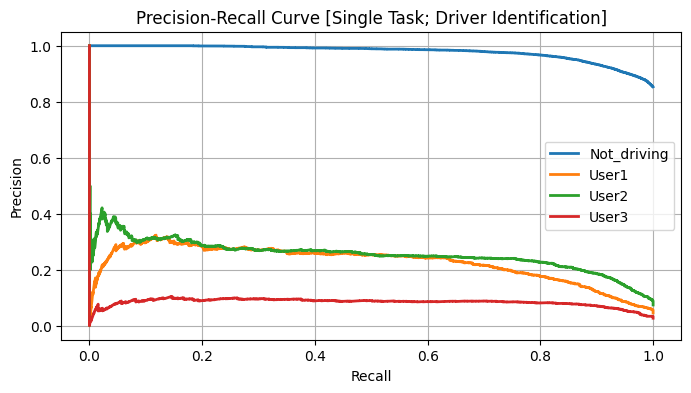

In [241]:
plot_precRec_curve(drv_prec, drv_rec, drv_classes, drv_num_classes, title="Precision-Recall Curve [Single Task; Driver Identification]")

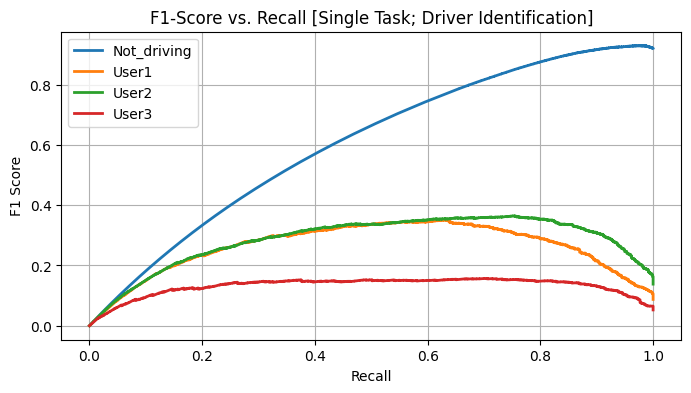

In [242]:
plot_F1rec_curve(drv_rec, drv_f1, drv_classes, drv_num_classes, title="F1-Score vs. Recall [Single Task; Driver Identification]")

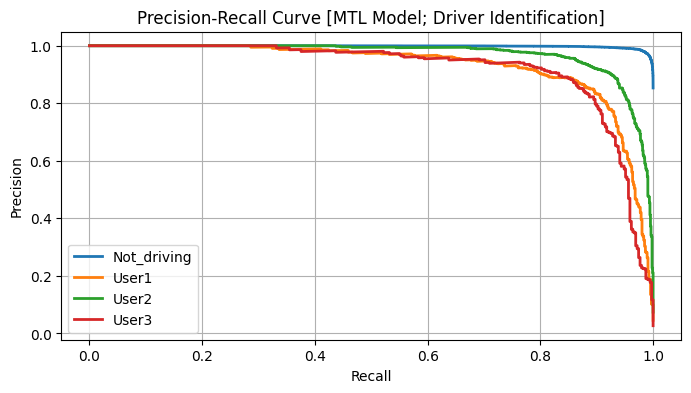

In [243]:
plot_precRec_curve(MTL_drv_prec, MTL_drv_rec, drv_classes, drv_num_classes, title="Precision-Recall Curve [MTL Model; Driver Identification]")

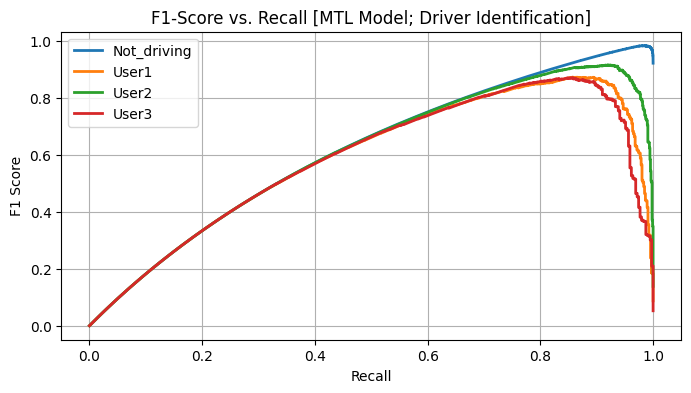

In [244]:
plot_F1rec_curve(MTL_drv_rec, MTL_drv_f1, drv_classes, drv_num_classes, title="F1-Score vs. Recall [MTL Model; Driver Identification]")

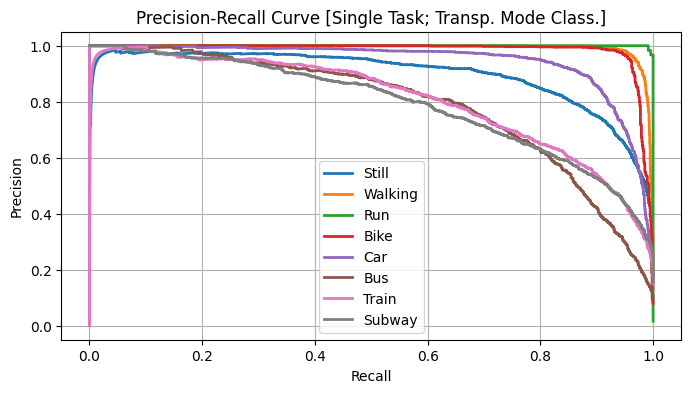

In [245]:
plot_precRec_curve(trp_prec, trp_rec, trp_classes, trp_num_classes, title="Precision-Recall Curve [Single Task; Transp. Mode Class.]")

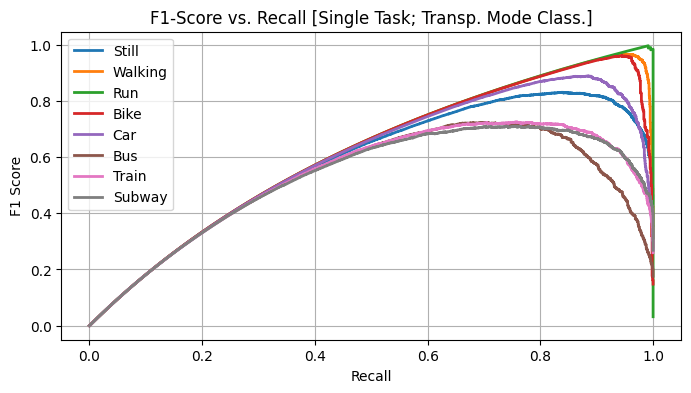

In [246]:
plot_F1rec_curve(trp_rec, trp_f1, trp_classes, trp_num_classes, title="F1-Score vs. Recall [Single Task; Transp. Mode Class.]")

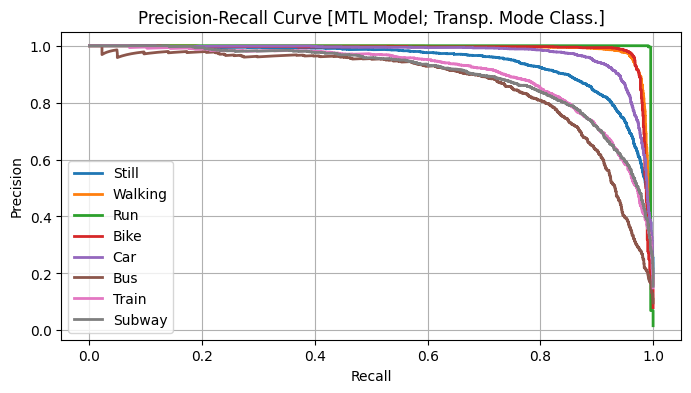

In [247]:
plot_precRec_curve(MTL_trp_prec, MTL_trp_rec, trp_classes, trp_num_classes, title="Precision-Recall Curve [MTL Model; Transp. Mode Class.]")

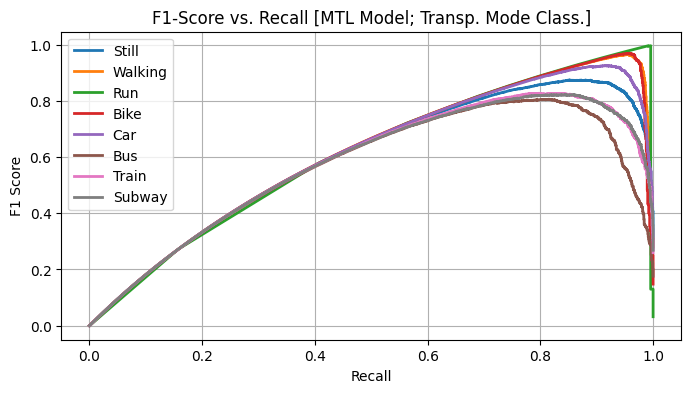

In [248]:
plot_F1rec_curve(MTL_trp_rec, MTL_trp_f1, trp_classes, trp_num_classes, title="F1-Score vs. Recall [MTL Model; Transp. Mode Class.]")

**Plotting Learning Curves and Accuracy Curves**

In [271]:
def plot_learning_curve(train_loss, val_loss, title='Learning Curves with Confidence Intervals', legend_text='XX'):
      # Compute mean and standard deviation
      train_mean = np.mean(train_loss, axis=0)
      train_std = np.std(train_loss, axis=0)
      val_mean = np.mean(val_loss, axis=0)
      val_std = np.std(val_loss, axis=0)

      epochs = np.arange(1, len(train_mean)+1)
      n_seeds = train_loss.shape[0]

      # Compute confidence intervals (95% CI)
      ci_multiplier = 1.96 / np.sqrt(n_seeds)
      train_ci = ci_multiplier * train_std
      val_ci = ci_multiplier * val_std

      # Plotting
      plt.figure(figsize=(8, 4))
      plt.plot(epochs, train_mean, label='Training Loss', color='blue')
      plt.fill_between(epochs, train_mean - train_ci, train_mean + train_ci, color='blue', alpha=0.2)

      plt.plot(epochs, val_mean, label='Validation Loss', color='red')
      plt.fill_between(epochs, val_mean - val_ci, val_mean + val_ci, color='red', alpha=0.2)

      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.title(title)
      plt.legend(title=legend_text)
      plt.grid(True)
      plt.show()

def plot_accuracy(train_accuracies, val_accuracies, title='Accuracy Plot with Confidence Intervals', legend_text='XX'):
      # Compute mean and standard deviation
      train_mean = np.mean(train_accuracies, axis=0)
      train_std = np.std(train_accuracies, axis=0)
      val_mean = np.mean(val_accuracies, axis=0)
      val_std = np.std(val_accuracies, axis=0)

      epochs = np.arange(1, len(train_mean)+1)
      n_seeds = train_accuracies.shape[0]

      # Compute confidence intervals (95% CI)
      ci_multiplier = 1.96 / np.sqrt(n_seeds)
      train_ci = ci_multiplier * train_std
      val_ci = ci_multiplier * val_std

      # Plotting
      plt.figure(figsize=(8, 4))
      plt.plot(epochs, train_mean, label='Training Accuracy', color='blue')
      plt.fill_between(epochs, train_mean - train_ci, train_mean + train_ci, color='blue', alpha=0.2)

      plt.plot(epochs, val_mean, label='Validation Accuracy', color='red')
      plt.fill_between(epochs, val_mean - val_ci, val_mean + val_ci, color='red', alpha=0.2)

      plt.xlabel('Epochs')
      plt.ylabel('Accuracy')
      plt.title(title)
      plt.legend(title=legend_text)
      plt.grid(True)
      plt.show()


In [252]:
def read_save_hist(file_list, MTL):
    if MTL:
        # Initialize dictionaries to hold the stacked history data
        tr_loss = []
        tr_acc_TRP = []
        tr_acc_DRV = []
        val_loss = []
        val_acc_TRP = []
        val_acc_DRV = []
        
        for idx, file_path in enumerate(file_list):
            # Load the history data from each file
            history = np.load(file_path, allow_pickle=True)
            # Append the history data to the respective lists
            tr_loss.append(history[0])
            val_loss.append(history[1])
            tr_acc_TRP.append(history[2])
            val_acc_TRP.append(history[3])
            tr_acc_DRV.append(history[4])
            val_acc_DRV.append(history[5])
        
        # Stack the lists to form a single numpy array per metric
        tr_loss = np.stack(tr_loss)
        val_loss = np.stack(val_loss)
        tr_acc_TRP = np.stack(tr_acc_TRP)
        val_acc_TRP = np.stack(val_acc_TRP)
        tr_acc_DRV = np.stack(tr_acc_DRV)
        val_acc_DRV = np.stack(val_acc_DRV)
        
        return tr_loss, tr_acc_TRP, tr_acc_DRV, val_loss, val_acc_TRP, val_acc_DRV
    
    else:
        # Initialize dictionaries to hold the stacked history data
        tr_loss = []
        tr_acc = []
        val_loss = []
        val_acc = []
        
        for idx, file_path in enumerate(file_list):
            # Load the history data from each file
            history = np.load(file_path, allow_pickle=True)
            # Append the history data to the respective lists
            tr_loss.append(history[0])
            val_loss.append(history[1])
            tr_acc.append(history[2])
            val_acc.append(history[3])
        
        # Stack the lists to form a single numpy array per metric
        tr_loss = np.stack(tr_loss)
        val_loss = np.stack(val_loss)
        tr_acc = np.stack(tr_acc)
        val_acc = np.stack(val_acc)
        
        return tr_loss, tr_acc, val_loss, val_acc

def get_trVal_loss_acc(file_list, MTL=False):
    if MTL:
        tr_loss, tr_acc_TRP, tr_acc_DRV, val_loss, val_acc_TRP, val_acc_DRV = read_save_hist(file_list, MTL=True)
        return tr_loss, tr_acc_TRP, tr_acc_DRV, val_loss, val_acc_TRP, val_acc_DRV
    else:
        tr_loss, tr_acc, val_loss, val_acc = read_save_hist(file_list, MTL=False)
        return tr_loss, tr_acc, val_loss, val_acc


In [263]:
drv_list = ["./model_checkpoint/seed_192_driver1D_ResNet50GRU_history.npy",
            "./model_checkpoint/seed_117_driver1D_ResNet50GRU_history.npy",
            "./model_checkpoint/seed_47_driver1D_ResNet50GRU_history.npy",
            "./model_checkpoint/seed_172_driver1D_ResNet50GRU_history.npy",
            "./model_checkpoint/run3_driver1D_ResNet50GRU_history.npy"]

trp_hist = ["./model_checkpoint/seed_192_transpMode_BiLSTM_history.npy",
            "./model_checkpoint/seed_117_transpMode_BiLSTM_history.npy",
            "./model_checkpoint/seed_47_transpMode_BiLSTM_history.npy",
            "./model_checkpoint/seed_172_transpMode_BiLSTM_history.npy",
            "./model_checkpoint/run2_40epochs_transpMode_BiLSTM_history.npy"]

MTL_hist = ["./model_checkpoint/seed_47_MTL_model_history.npy",
            "./model_checkpoint/seed_172_MTL_model_history.npy",
            "./model_checkpoint/run1_MTL_model_history.npy",
            "./model_checkpoint/seed_192_MTL_model_history.npy",
            "./model_checkpoint/seed_117_MTL_model_history.npy"]

DRV_tr_loss, DRV_tr_acc, DRV_val_loss, DRV_val_acc = get_trVal_loss_acc(drv_list)
TRP_tr_loss, TRP_tr_acc, TRP_val_loss, TRP_val_acc = get_trVal_loss_acc(trp_hist)
MTL_tr_loss, MTL_tr_acc_TRP, MTL_tr_acc_DRV, MTL_val_loss, MTL_val_acc_TRP, MTL_val_acc_DRV = get_trVal_loss_acc(MTL_hist, MTL=True)

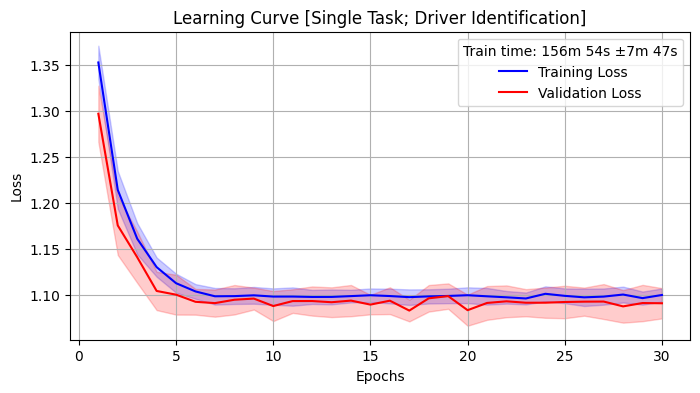

In [283]:
plot_learning_curve(DRV_tr_loss, DRV_val_loss, title='Learning Curve [Single Task; Driver Identification]', legend_text='Train time: 156m 54s ±7m 47s')

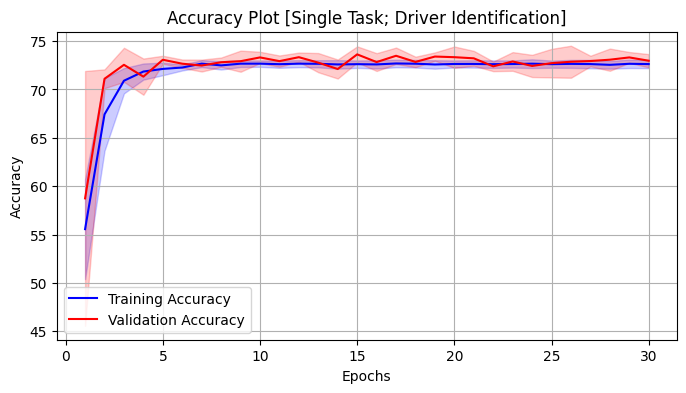

In [284]:
plot_accuracy(DRV_tr_acc, DRV_val_acc, title='Accuracy Plot [Single Task; Driver Identification]', legend_text='')

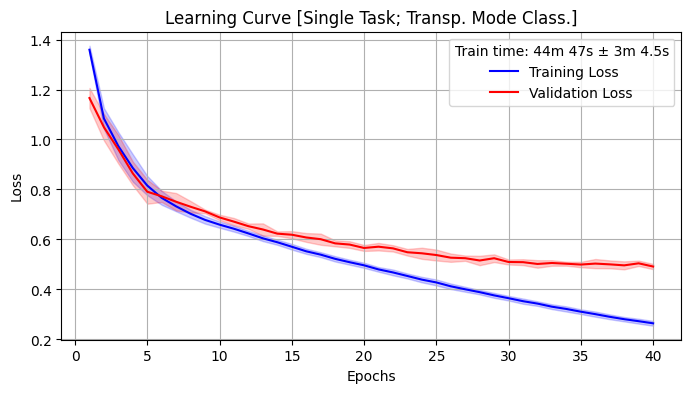

In [285]:
plot_learning_curve(TRP_tr_loss, TRP_val_loss, title='Learning Curve [Single Task; Transp. Mode Class.]', legend_text='Train time: 44m 47s ± 3m 4.5s')

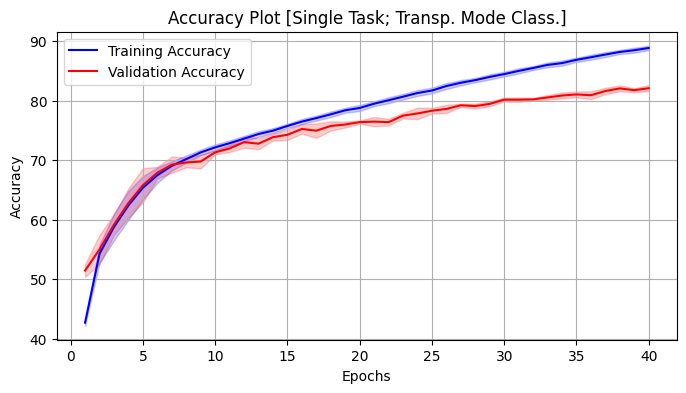

In [286]:
plot_accuracy(TRP_tr_acc, TRP_val_acc, title='Accuracy Plot [Single Task; Transp. Mode Class.]', legend_text='')

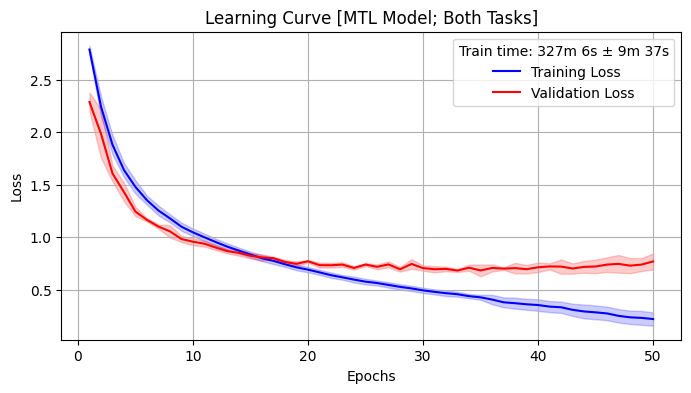

In [287]:
plot_learning_curve(MTL_tr_loss, MTL_val_loss, title='Learning Curve [MTL Model; Both Tasks]', legend_text='Train time: 327m 6s ± 9m 37s')

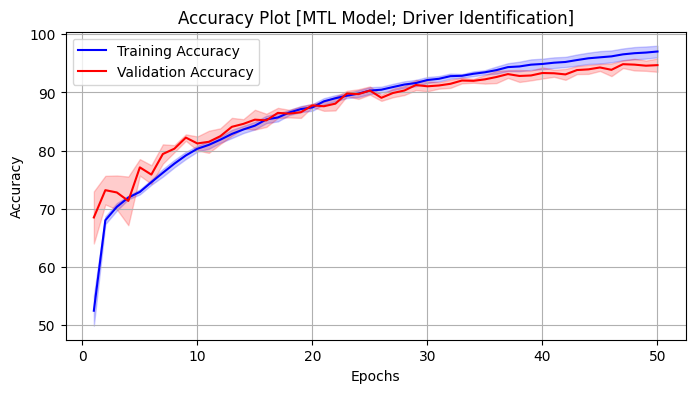

In [288]:
plot_accuracy(MTL_tr_acc_DRV, MTL_val_acc_DRV, title='Accuracy Plot [MTL Model; Driver Identification]', legend_text='')

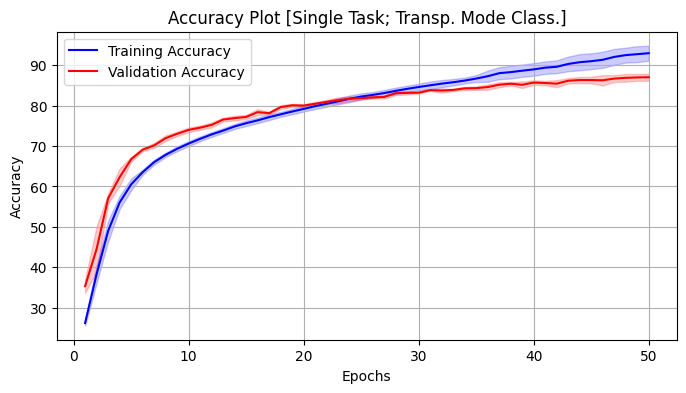

In [289]:
plot_accuracy(MTL_tr_acc_TRP, MTL_val_acc_TRP, title='Accuracy Plot [Single Task; Transp. Mode Class.]', legend_text='')